# Data Processing for Logistic Regression with Linear Features

---

Our problem requires classification prediction. Logistic regression is one of the good algorithm to base our model on.

As with all regression algorithms, Logistic Regression is very sensitive to outliers and abnormal data distribution, regardless if we are using polynomial features or not. And if we are using polynomial features, feature scaling also becomes an important step in our data processing.

Thus, data processing for Logistic Regression (using either linear or polynomial features) can be summarized in the following steps:

**For training dataset:**

1. Deal with outliers;
2. Transform data into normal distribution;
3. Rescale features;
4. Feature sampling (because our training data is imbalanced as analyzed in [Step 1. EDA](../Step1.EDA.ipynb);
5. Further feature engineering to improve our model's performance...

*Note:* The target is already processed adequately in [Step 2. Data Preprocessing](../Step2.DataPreprocessing.ipynb), so there is no need to process it.

**For test dataset (would be done before using our model to predict):**
1. Transform data into normal distribution;
2. Rescale features.

In [1]:
# Imports and environment setup

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

# Custom utils functions
from utils import header
from utils import show_distribution
from utils import show_aggregate_distribution


# Load our dataset
df_train = pd.read_csv("../../data/train.csv")
df_test = pd.read_csv("../../data/test.csv")

In [2]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRG     599 non-null    int64  
 1   PL      599 non-null    int64  
 2   PR      599 non-null    int64  
 3   SK      599 non-null    int64  
 4   TS      599 non-null    int64  
 5   M11     599 non-null    float64
 6   BD2     599 non-null    float64
 7   Age     599 non-null    int64  
 8   Sepsis  599 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 42.2 KB


,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484,0.347245
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446,0.476492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
df_test.info()
df_test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRG     169 non-null    int64  
 1   PL      169 non-null    int64  
 2   PR      169 non-null    int64  
 3   SK      169 non-null    int64  
 4   TS      169 non-null    int64  
 5   M11     169 non-null    float64
 6   BD2     169 non-null    float64
 7   Age     169 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 10.7 KB


,PRG,PL,PR,SK,TS,M11,BD2,Age
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,3.917160,123.520710,70.426036,20.443787,81.000000,32.249704,0.438876,33.065089
std,3.402415,29.259123,19.426805,15.764962,110.720852,7.444886,0.306935,11.548110
min,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.100000,21.000000
25%,1.000000,102.000000,62.000000,0.000000,0.000000,27.600000,0.223000,24.000000
50%,3.000000,120.000000,74.000000,23.000000,0.000000,32.400000,0.343000,28.000000
75%,6.000000,141.000000,80.000000,32.000000,135.000000,36.600000,0.587000,42.000000
max,13.000000,199.000000,114.000000,49.000000,540.000000,57.300000,1.698000,70.000000


## 1. Baseline Model

We are going to set up a baseline Logistic Regression model. Note: We are only using linear features here for simplicity, and will optimize our model by trying polynomial features later on when we focus on developing our logistic regression model.


We will be using [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) to measure our model's performance and optimize it. While every sepsis case needs immediate attention, thus every potential sepsis patient needs close monitering, false positive predictions might take medical resources away from patients that might actually need it. In subsequent model development, if we see that recall and precision have different weights in our problem domain, we can switch to [F-beta](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#:~:text=The%20F-beta%20score%20is,recall%20in%20the%20combined%20score.) instead.

There will be no regularization to keep things simple, since at this point we only care about how to best process our data. Regularization will be introduced later when we focus on fine-tuning our model.

This baseline model will be trained on raw training data and its performance would be the baseline for us to find out how to best process our data. Since our training dataset is small (599 datapoints), K-fold cross validation is the best option to validate our model's performance. With that said, here we are not trying to find the best model, but the best data processing scheme for our Logistic Regression model. Thus, we will be using simple holdout cross validation.

**Note:** Reproducibility of our results is important in this context.

Separate our features (X) and target (Y):

In [4]:
df_X = df_train.drop(["Sepsis"], axis=1)
df_y = df_train[["Sepsis"]]

In [5]:
df_X.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [6]:
df_y.head()

,Sepsis
0,1.0
1,0.0
2,1.0
3,0.0
4,1.0


Splitting our raw training data into a train set and a test set:

In [7]:
train_X, test_X, train_y, test_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=99,  # Ensure reproducible results
    test_size=0.2
)

train_y = train_y["Sepsis"].values
test_y = test_y["Sepsis"].values

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_X shape: {test_X.shape}")
print(f"test_y shape: {test_y.shape}")

train_X shape: (479, 8)
train_y shape: (479,)
test_X shape: (120, 8)
test_y shape: (120,)


Training and validating our model using cross-validation (K-fold splitting), performance measured and optimized using F1 score:

In [8]:
baseline_clf = LogisticRegression(
    penalty=None,             # No regularization
    class_weight="balanced",  # Because our training data is imbalanced
    max_iter=1_000,
    random_state=99           # Reproducible result
)

baseline_clf.fit(train_X, train_y)
pred_y = baseline_clf.predict(train_X)

In [9]:
print(f"{header(53, 'BASELINE MODEL PERFORMANCE')}\n{classification_report(train_y, pred_y)}")

╔═══════════════════════════════════════════════════╗
║            BASELINE MODEL PERFORMANCE             ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       311
         1.0       0.64      0.73      0.69       168

    accuracy                           0.76       479
   macro avg       0.74      0.76      0.75       479
weighted avg       0.77      0.76      0.77       479



Our baseline model's performance key metrics:

|                  | F1 Score |
|:-----------------|---------:|
| Negative         |     0.81 |
| Positive         |     0.69 |
| Macro Average    |     0.75 |
| Weighted Average |     0.77 |

Our model is somewhat above average at the moment. It is also better at predicting Negative cases versus Positive cases, which is undesirable for our purpose. We want it to predict both classes equally well, or at least predict the Positive class better.

Let's see if we can improve this with data processing.

## 2. Data Processing

We will go over each feature one by one.

In [10]:
df_train.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepsis
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484,0.347245
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446,0.476492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [11]:
df_test.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,3.917160,123.520710,70.426036,20.443787,81.000000,32.249704,0.438876,33.065089
std,3.402415,29.259123,19.426805,15.764962,110.720852,7.444886,0.306935,11.548110
min,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.100000,21.000000
25%,1.000000,102.000000,62.000000,0.000000,0.000000,27.600000,0.223000,24.000000
50%,3.000000,120.000000,74.000000,23.000000,0.000000,32.400000,0.343000,28.000000
75%,6.000000,141.000000,80.000000,32.000000,135.000000,36.600000,0.587000,42.000000
max,13.000000,199.000000,114.000000,49.000000,540.000000,57.300000,1.698000,70.000000


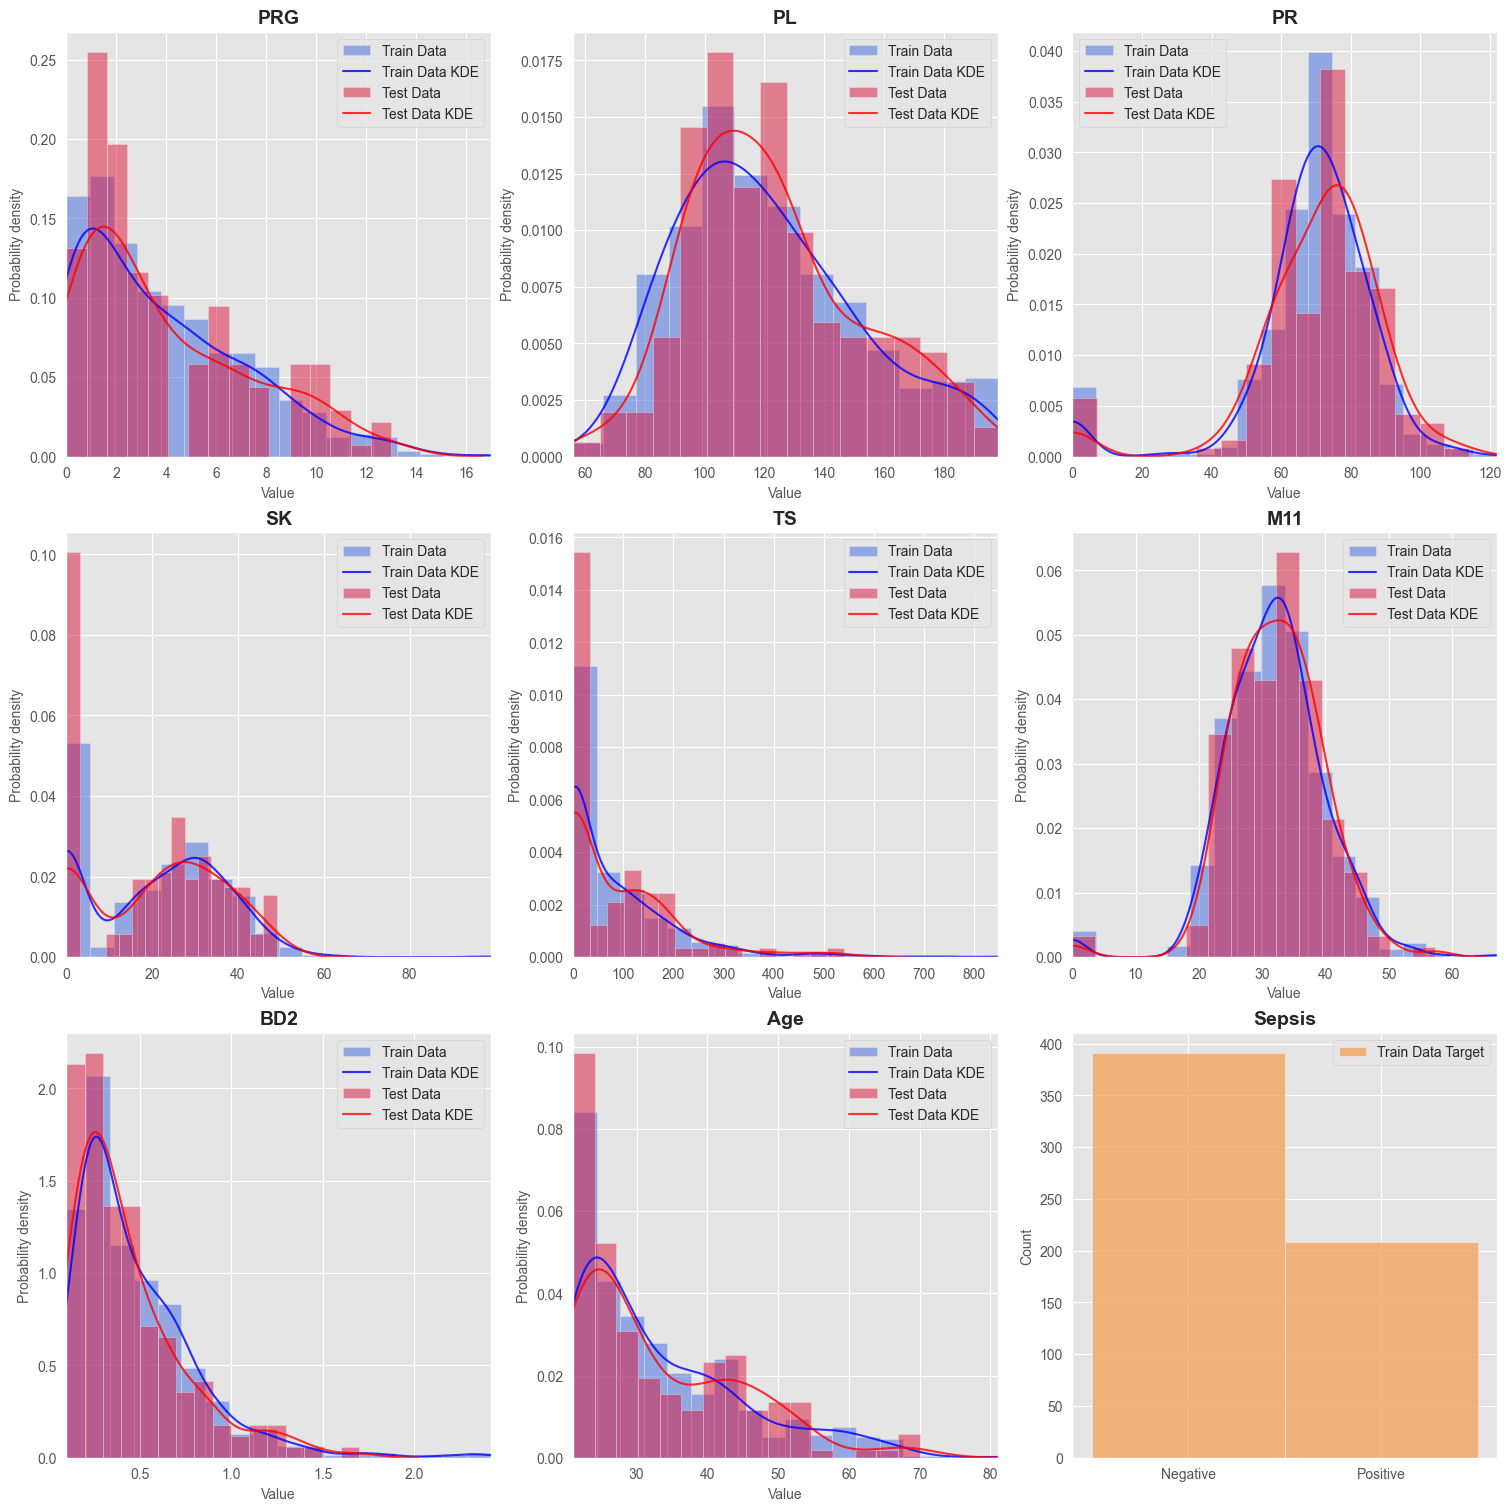

In [12]:
show_aggregate_distribution(df_train, df_test)

### 2.1. PRG

Plasma glucose.

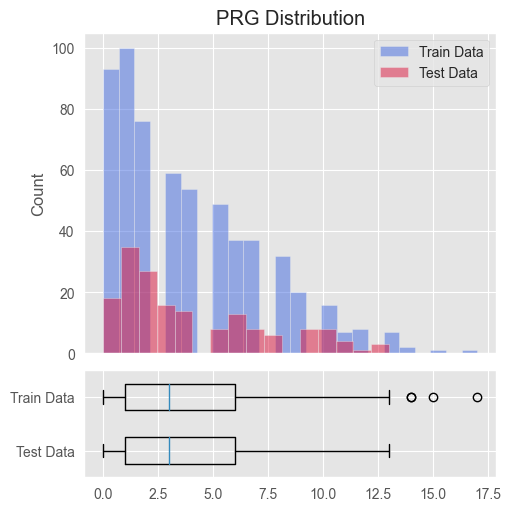

        PRG_TRAIN    PRG_TEST
count  599.000000  169.000000
mean     3.824708    3.917160
std      3.362839    3.402415
min      0.000000    0.000000
25%      1.000000    1.000000
50%      3.000000    3.000000
75%      6.000000    6.000000
max     17.000000   13.000000


In [13]:
show_distribution("PRG", df_train, df_test)

We see that PRG has exponential distribution, so perhaps normalizing its distribution will reduce the effect of outliers without us having to further deal with them.

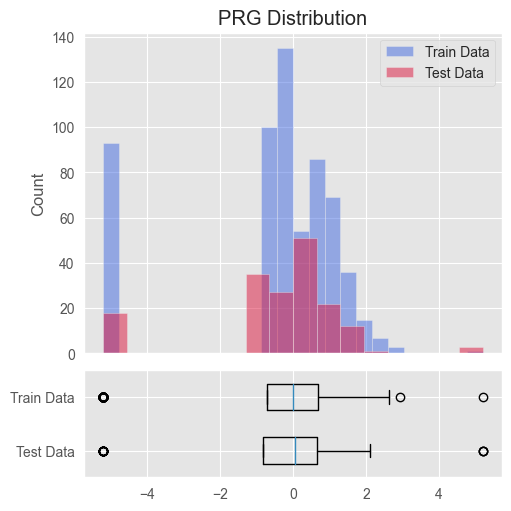

        PRG_TRAIN    PRG_TEST
count  599.000000  169.000000
mean    -0.563270   -0.313265
std      2.124099    1.957485
min     -5.199338   -5.199338
25%     -0.711800   -0.812218
50%     -0.004192    0.059717
75%      0.677123    0.646652
max      5.199338    5.199338


In [14]:
train_PRG_transformed2 = pd.DataFrame(QuantileTransformer(output_distribution="normal", n_quantiles=min(len(df_train), 1000)).fit_transform(df_train[["PRG"]] + 0.1), columns=["PRG"])
test_PRG_transformed2 = pd.DataFrame(QuantileTransformer(output_distribution="normal", n_quantiles=min(len(df_test), 1000)).fit_transform(df_test[["PRG"]] + 0.1), columns=["PRG"])

show_distribution("PRG", train_PRG_transformed2, test_PRG_transformed2)